In [1]:
from rastervision.core.data import (
    RasterioCRSTransformer,
    GeoJSONVectorSource,
    ClassConfig,
    ClassInferenceTransformer,
    SemanticSegmentationLabelSource,
    RasterioSource,
    RasterizedSource)

import os

2023-04-17 21:49:43:rastervision.pipeline.rv_config: WARNING - Root temporary directory cannot be used: /opt/data/tmp. Using root: /tmp/tmpq3eldi74


In [2]:
#Function call to convert DN to class_id
def convert_feature_to_class_id(feature_name:str):
    #This modifies the underlying GeoJSON in vector_source
    try:
        for feature in vector_data['features']:
            feature['properties']['class_id'] = feature['properties'].pop(feature_name)
    except:
        print("The feature does not exist in the dictionary")
        

#Function to remove the null classes
def remove_unwanted_classes(geojson:dict, inplace = False):
    if inplace == False:
        from copy import deepcopy
        mod_geojson = deepcopy(geojson)
    else:
        mod_geojson = geojson
    num_points = {k:0 for k in range(12)}
    num_points_after = {k:0 for k in range(12)}
    classes_to_show = []
    
    for feature in mod_geojson['features']:
        # Get the current class_id
        # Getting the class memberships
        class_id = feature['properties']['class_id']
        num_points[class_id]+=1

    

    print("Class Membership(Before)")
    for k,v in num_points.items():
        print(k, v)
        if v!=0 or k==0:
            classes_to_show.append(k)
    
    #Get the classes with 0 points in them
    remove_classes = [3,6,10]
    remove_classes.sort()
    remove_classes = list(map(lambda x: x - remove_classes.index(x),remove_classes))
    
    #Iterate through remove_classes and shift class_id (only for 3, 6 and 10)
    for remove_id in remove_classes:
        for feature in mod_geojson['features']:
            class_id = feature['properties']['class_id']
            if class_id > remove_id:
                feature['properties']['class_id'] = class_id - 1
                
    for feature in mod_geojson['features']:
    # Get the current class_id
    # Getting the class memberships
        class_id = feature['properties']['class_id']
        num_points_after[class_id]+=1
    
    
    print("\n\nClass Membership(After)")
    for k,v in num_points_after.items():
        print(k, v)
    
    if inplace == False:
        return mod_geojson
    

In [3]:
INFERENCE_IMAGES_VECTORS = '../data/Inference Images'

In [4]:
all_images = [os.path.join(INFERENCE_IMAGES_VECTORS,file) for file in os.listdir(INFERENCE_IMAGES_VECTORS) if file.endswith('.tif')]
all_images.sort()
all_images

['../data/Inference Images/AUS_Sentinel-2_2021.tif',
 '../data/Inference Images/DubaiMall_Sentinel-2_2021_UAE.tif']

In [5]:
all_vector_data = [os.path.join(INFERENCE_IMAGES_VECTORS,file) for file in os.listdir(INFERENCE_IMAGES_VECTORS) if file.endswith('.geojson')]
all_vector_data

['../data/Inference Images/AUS_2021_Polygon.geojson',
 '../data/Inference Images/DubaiMall_2021_Polygon.geojson']

In [6]:
#Loading a given Satellite Image
raster_tile_1 = RasterioSource(all_images[0],
                               channel_order=[2,1,0],
                               allow_streaming = False)
raster_tile_arr = raster_tile_1.get_image_array()

Warning 1: PROJ: proj_create_from_database: /home/ac18/miniconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [7]:
raster_tile_arr.shape

(206, 228, 3)

In [8]:
#Loading the corresponding Label (Vector Polygon file)
crs_transformer = RasterioCRSTransformer.from_uri(all_images[0])

vector_source = GeoJSONVectorSource(all_vector_data[0],
                                    crs_transformer,
                                    ignore_crs_field=True,
                                    vector_transformers=[ClassInferenceTransformer(default_class_id=0)])

In [9]:
vector_data = vector_source.get_geojson()

In [10]:
# Viewing vector_data in JSON style
vector_data

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'geometry': {'type': 'Polygon',
    'coordinates': (((186.0, 0.0),
      (185.0, 0.0),
      (185.0, 2.0),
      (186.0, 2.0),
      (186.0, 0.0)),)},
   'properties': {'fid': 7162, 'DN': 11, 'class_id': 0}},
  {'type': 'Feature',
   'geometry': {'type': 'Polygon',
    'coordinates': (((135.0, 1.0),
      (135.0, 0.0),
      (132.0, 0.0),
      (132.0, 5.0),
      (133.0, 5.0),
      (133.0, 6.0),
      (134.0, 6.0),
      (134.0, 1.0),
      (135.0, 1.0)),)},
   'properties': {'fid': 7165, 'DN': 11, 'class_id': 0}},
  {'type': 'Feature',
   'geometry': {'type': 'Polygon',
    'coordinates': (((182.0, 5.0),
      (181.0, 5.0),
      (181.0, 7.0),
      (182.0, 7.0),
      (182.0, 5.0)),)},
   'properties': {'fid': 7175, 'DN': 11, 'class_id': 0}},
  {'type': 'Feature',
   'geometry': {'type': 'Polygon',
    'coordinates': (((45.0, 0.0),
      (38.0, 0.0),
      (37.0, 0.0),
      (37.0, 1.0),
      (36.0, 1.0),
      (36

In [11]:
#Renames 'DN' into 'class_id'
convert_feature_to_class_id('DN')

In [12]:
#Removes the empty classes and gives info on class membership
remove_unwanted_classes(vector_data,inplace = True)

Class Membership(Before)
0 0
1 0
2 0
3 0
4 0
5 11
6 0
7 11
8 11
9 0
10 0
11 25


Class Membership(After)
0 0
1 0
2 0
3 0
4 11
5 11
6 11
7 0
8 25
9 0
10 0
11 0


In [13]:
rasterized_source = RasterizedSource(
    vector_source,
    background_class_id=0,
    extent=raster_tile_1.extent) # RasterSource's extent = Extent of Satellite Image

In [14]:
# Getting the array of the label
vector_raster = rasterized_source.get_image_array()

In [15]:
vector_raster.shape

(206, 228, 1)

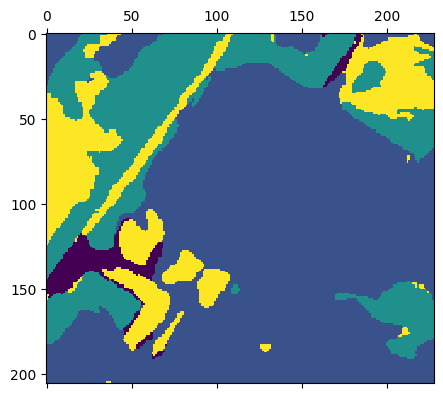

In [16]:
#Visualize the label raster
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(vector_raster)
plt.show()

In [17]:
for i in vector_raster:
    print(i)

[[5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]
 [8]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [8]
 [8]
 [8]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [8]
 [8]
 [8]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [4]
 [4]
 [4]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [4]
 [4]
 [4]
 [8]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]


Warning 1: PROJ: proj_create_from_database: /home/ac18/miniconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


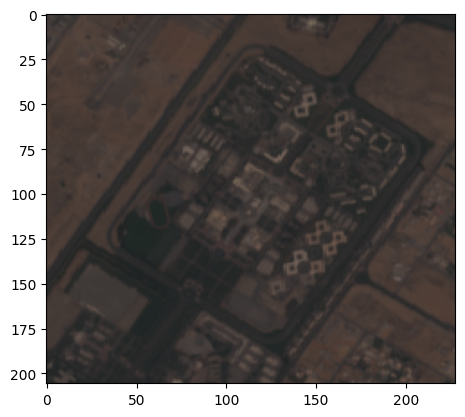

In [18]:
plt.imshow(raster_tile_1.get_image_array())

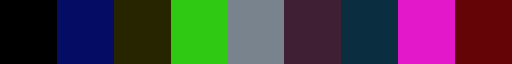

In [19]:
#Creating Class Config
class_config = ClassConfig(names = ["null",
                                   "Water",
                                   "Trees",
                                   "Floded Vegetation",
                                   "Crops",
                                   "Built Area",
                                   "Bare Ground",
                                   "Snow/Ice",
                                   "Rangeland"])

#Setting color for null to black
class_config.colors[0] = 'black'
class_config.colors[1] = (4, 12, 100)
class_config.colors[2] = (39, 36, 0)
class_config.colors[3] = (47, 201, 19)
class_config.colors[4] = (121, 131, 141)
class_config.colors[5] = (63, 31, 52)
class_config.colors[6] = (10, 45, 63)
class_config.colors[7] = (226, 24, 202)
class_config.colors[8] = (100, 4, 6)

#Color card representing the data
from matplotlib.colors import ListedColormap
cmap = ListedColormap(class_config.color_triples)
cmap

In [20]:
label_rasters = SemanticSegmentationLabelSource(
                rasterized_source, class_config = class_config)
label_raster_arr = label_rasters.get_label_arr()

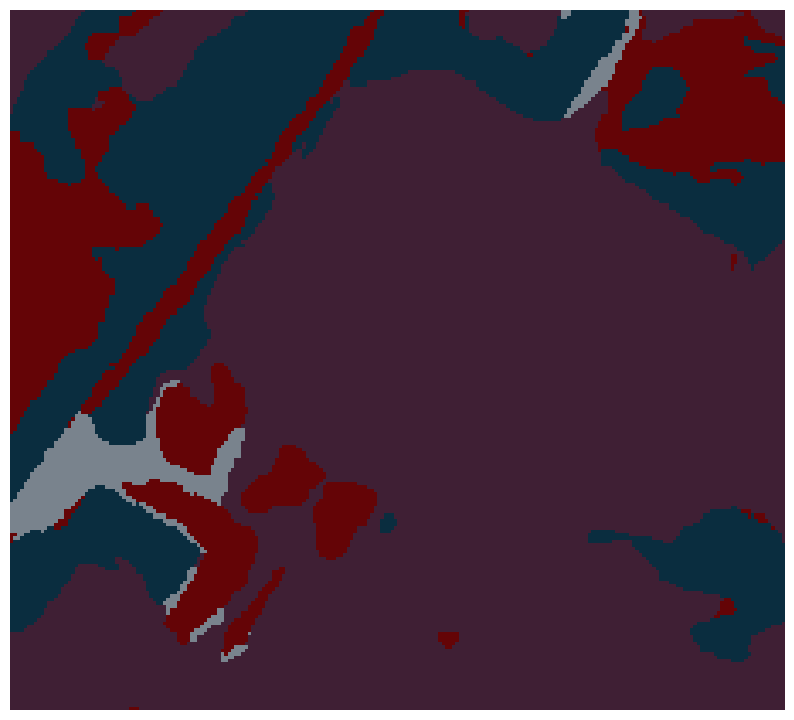

In [23]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import patches

fig,ax = plt.subplots(figsize=(10,10),frameon=False)
ax.set_axis_off()
cmap = ListedColormap(class_config.color_triples)
ax.imshow(label_raster_arr, cmap = cmap, vmin=0, vmax=8)

# legend_items = [
#     patches.Patch(facecolor=cmap(i),edgecolor='black',label=cname)
#     for i, cname in enumerate(class_config.names)]
# ax.legend(
#     handles=legend_items,
#     ncol=len(class_config),
#     loc='upper center',
#     fontsize=14,
#     bbox_to_anchor=(0.5,0))
plt.savefig(os.path.join(INFERENCE_IMAGES_VECTORS,"AUS_2021.png"),bbox_inches='tight',transparent=True, pad_inches=0)